The task in this notebook is to train a network which, given an image of a star, will calculate both the number of points on the star, as well as its width.

Thus this will be a multi-task network, performing two completely different tasks simultaneously.


In [ ]:
#%% import stuff:

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader

The cell below assumes you have already downloaded the dataset from brightspace, and put it in your google drive folder. It demonstrates how to use google drive together with a colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


temp=pickle.load(open('/content/drive/MyDrive/starData.p','rb'))
X=temp['X']
y=temp['y']


Mounted at /content/drive


tensor([5.0000, 3.1239])


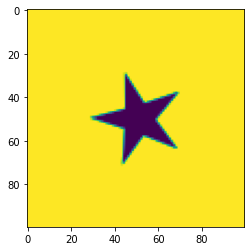

In [ ]:
#Let's plot an example
idx=125
plt.imshow(np.squeeze(X[125,:,:,:],axis=0))
print(y[idx,:]) #first column is number of points, second is size of the star

In [ ]:
#%% make datasets & loaders

#split in val and train:
nData=X.shape[0]
nVal=300
valIdx=range(nVal)
trainIdx=range(nVal+1,nData)

#datasets:
trainDataset=torch.utils.data.TensorDataset(X[trainIdx,:,:,:],y[trainIdx,:])
valDataset=torch.utils.data.TensorDataset(X[valIdx,:,:,:],y[valIdx,:])

#dataloaders:
trainLoader=torch.utils.data.DataLoader(trainDataset,batch_size=32,shuffle=True)
valLoader=torch.utils.data.DataLoader(valDataset,batch_size=32,shuffle=True)

In [ ]:
#%% make network

#something simple like cnn-cnn-fc-relu-fc will do

import torch.nn as nn
import torch.nn.functional as F

num_classes= 10

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5,stride=1,padding=2)
        self.cnn2=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5,stride=2,padding=2)

        self.fc1=nn.Linear(50*50, 80, bias=True)
        self.leakRelu1=nn.LeakyReLU()
        self.fc2=nn.Linear(80, 2, bias=True)
        self.leakRelu2=nn.LeakyReLU()

    def forward(self,x):
        x=self.cnn1(x)
        x=self.cnn2(x)
        x=torch.reshape(x,(-1,50*50))
        x=self.fc1(x)
        x=self.leakRelu1(x)
        x=self.fc2(x)
        return x

net = Net()
print(net)

#testing:
testData=torch.rand((1,1,100,100))
testNet=Net()
testNet.forward(testData)

Net(
  (cnn1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (cnn2): Conv2d(1, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=2500, out_features=80, bias=True)
  (leakRelu1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=80, out_features=2, bias=True)
  (leakRelu2): LeakyReLU(negative_slope=0.01)
)


tensor([[-0.0065,  0.0259]], grad_fn=<AddmmBackward0>)

In [ ]:
#%% define loss'es
loss1=nn.SmoothL1Loss(reduction='sum',beta=0.05)
loss2=nn.SmoothL1Loss(reduction='sum',beta=0.05)
loss_fn = lambda pred,target : 0.5*loss1(pred[:,0],target[:,0].float())+0.5*loss2(pred[:,1],target[:,1])

0
tensor(1039.4407, grad_fn=<DivBackward0>)
tensor(1051.9120, grad_fn=<DivBackward0>)
1
tensor(42.5577, grad_fn=<DivBackward0>)
tensor(51.9593, grad_fn=<DivBackward0>)
2
tensor(43.5128, grad_fn=<DivBackward0>)
tensor(50.4492, grad_fn=<DivBackward0>)
3
tensor(30.8851, grad_fn=<DivBackward0>)
tensor(36.0781, grad_fn=<DivBackward0>)
4
tensor(29.1212, grad_fn=<DivBackward0>)
tensor(34.4837, grad_fn=<DivBackward0>)
5
tensor(29.8853, grad_fn=<DivBackward0>)
tensor(34.7459, grad_fn=<DivBackward0>)
6
tensor(30.4229, grad_fn=<DivBackward0>)
tensor(38.3696, grad_fn=<DivBackward0>)
7
tensor(29.6243, grad_fn=<DivBackward0>)
tensor(34.5768, grad_fn=<DivBackward0>)
8
tensor(26.5014, grad_fn=<DivBackward0>)
tensor(32.1841, grad_fn=<DivBackward0>)
9
tensor(25.6595, grad_fn=<DivBackward0>)
tensor(30.3587, grad_fn=<DivBackward0>)
10
tensor(26.9964, grad_fn=<DivBackward0>)
tensor(33.4326, grad_fn=<DivBackward0>)
11
tensor(27.8116, grad_fn=<DivBackward0>)
tensor(33.2707, grad_fn=<DivBackward0>)
12
tensor(

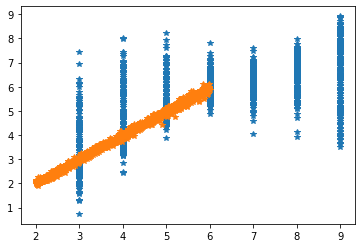

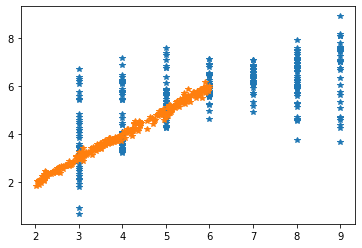

In [ ]:
#%% train & validate

nEpoch= 30

net=Net()
optimizer= torch.optim.Adam(net.parameters())


# equivalently, define the loss as a usual function object instead of a lambda function
def loss_equivalent(pred, target):
  loss = loss1(pred[:,0],target[:,0].float())
  loss += loss2(pred[:,1],target[:,1])
  return 0.5*loss

for iEpoch in range(nEpoch):
    print(iEpoch)
    totLoss=0
    for xbatch,ybatch in trainLoader:

        ypred=net(xbatch)
        loss = loss_fn(ypred,ybatch)
        totLoss+=loss
        net.zero_grad()

        loss.backward()

        optimizer.step()

    print(totLoss/len(trainLoader))

    for xbatch,ybatch in valLoader:

        ypred=net(xbatch)
        loss = loss_fn(ypred,ybatch)
        totLoss+=loss

    print(totLoss/len(trainLoader))


trainy=np.zeros((0,2))
trainRes=np.zeros((0,2))

for xbatch,ybatch in trainLoader:

        ypred=net(xbatch)
        trainRes=np.concatenate((trainRes,ypred.detach().numpy()),axis=0)
        trainy=np.concatenate((trainy,ybatch.detach().numpy()),axis=0)

valy=np.zeros((0,2))
valRes=np.zeros((0,2))

for xbatch,ybatch in valLoader:

        ypred=net(xbatch)
        valRes=np.concatenate((valRes,ypred.detach().numpy()),axis=0)
        valy=np.concatenate((valy,ybatch.detach().numpy()),axis=0)


plt.close('all')
plt.plot(trainy,trainRes,'*')

plt.figure()
plt.plot(valy,valRes,'*')




#evaluate

try plotting predictions vs. targets for both training data and validation data in a scatterplot, and see how much variation you've captured